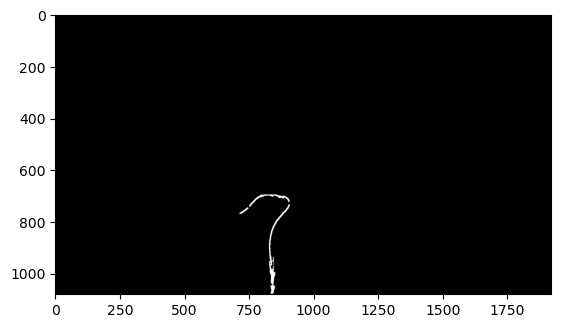

In [47]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

processed_segmentation_folder = 'Data/Datasets/RigidModelVideo-11-21/11-21-1-clip2/outputs_f_t_100/segmentation/filled_5'

#Maybe there is loss of precision cuz it's a jpeg
sample_segmentation = cv2.imread(f"{processed_segmentation_folder}/frame0767.jpg", cv2.IMREAD_GRAYSCALE) > 10
sample_segmentation = sample_segmentation.astype(np.uint8) * 255

plt.imshow(sample_segmentation, cmap='gray')


In [51]:
from skimage.morphology import skeletonize

def roubust_skeletonize(image):
    # Get the cross-shaped structuring element
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))

    # Initialize the skeleton to be the same size as the input image
    skeleton = np.zeros(image.shape, np.uint8)

    while True:
        # Erode the image
        eroded = cv2.erode(image, element)
        # Dilate the eroded image
        temp = cv2.dilate(eroded, element)
        # Subtract the temporary image from the original image
        temp = cv2.subtract(image, temp)
        # Bitwise OR the skeleton and temporary image
        skeleton = cv2.bitwise_or(skeleton, temp)
        # Update the image
        image = eroded.copy()

        # If there are no white pixels left in the image
        # i.e. the image has been completely eroded, break the loop
        if cv2.countNonZero(image) == 0:
            break

    return skeleton

filled = cv2.morphologyEx(sample_segmentation, cv2.MORPH_DILATE, np.ones((11, 11),np.uint8))
#We might not be able to skeletonize the perfect line?
skeleton = skeletonize(filled)
reconstructed = cv2.morphologyEx(skeleton.astype(np.uint8), cv2.MORPH_DILATE, cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5)))
cv2.imwrite('./test.png', skeleton.astype(np.uint8) * 255)

True

/home/zzy/miniconda3/envs/imaging/lib/python3.11/site-packages/fil_finder/filfinder2D.py:142: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
/home/zzy/miniconda3/envs/imaging/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/zzy/miniconda3/envs/imaging/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/zzy/miniconda3/envs/imaging/lib/python3.11/site-packages/fil_finder/filfinder2D.py:296: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
/home/zzy/miniconda3/envs/imaging/lib/python3.11/site-packages/fil_finder/filament.py:326: UserWarning: Graph pruning reached max iterations.

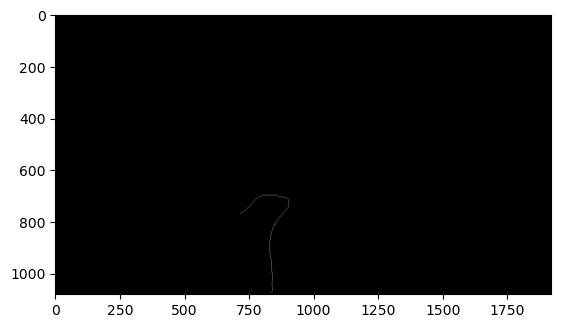

In [57]:
# Do purging branches
import os
os.environ['ASTROPY_SKIP_CONFIG_UPDATE'] = '1'
from fil_finder import FilFinder2D
from astropy import units as u

fil = FilFinder2D(skeleton.astype(np.uint8), distance=250 * u.pc, mask=skeleton.astype(np.uint8))
fil.preprocess_image(flatten_percent=85)
fil.create_mask(border_masking=True, verbose=False,use_existing_mask=True)
fil.medskel(verbose=False)
fil.analyze_skeletons(branch_thresh=40* u.pix, skel_thresh=10 * u.pix, prune_criteria='length')
plt.imshow(fil.skeleton_longpath, cmap='gray')
cv2


In [ ]:
# Mass processing

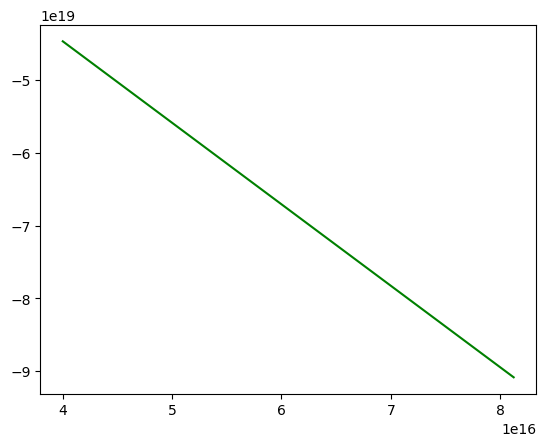

In [65]:
# Actually we want to do curve fitting cuz the skeleton is jagged,
# Or we just do early stopping
from scipy.interpolate import BSpline, make_smoothing_spline, splprep, splev

y, x = np.where(fil.skeleton_longpath)

sort_idx = np.argsort(x)
x = x[sort_idx].astype(float)
y = y[sort_idx].astype(float)
for i in range(1, len(x)):
    if x[i] <= x[i-1]:
        x[i] = x[i-1] + 0.01

tck, _ = splprep((x, y), k=3)
x_fit, y_fit = splev(x, tck)

# plt.imshow(sample_segmentation, cmap='gray')
# x_fit = np.linspace(x[0], x[-1], 1000)
# y_fit = spline(x_fit)
plt.plot(x_fit, y_fit, 'g-')
plt.show()